<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit4/TaviTragU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test scores in boys vs girls#


In [1]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


##Intro##

I once again had no idea what to study so I googled data set and found this. Here is the description they provided:


This dataset comes from The Associated Examining Board in Guildford,
and contents 1905 records. It has been used to examine the relationships
between candidates'genders and their examination performances.  Each
candidate comes from a centre ( a school or a college ). The dataset,
which relates only to part of one examination,  may only  be used for
teaching and training purposes. An analysis of the complete data set
and several others is reported in the first  reference quoted below.


I'm gonna make a hierarchical model to look at scores for boys and girls, and I think they are related because they are learning the same thing at the same places.


I found this data set on this website: https://www.bristol.ac.uk/cmm/learning/support/datasets/.

##The Data##


In [2]:
#importing data!
url_scores = 'https://raw.githubusercontent.com/TaviTragus/data-science-fundamentals/refs/heads/main/Unit4/publicexamscores.csv'
data_scores = pd.read_csv(url_scores,dtype={'Gc':'category'})
data_scores

,Cwaccf,Ci,Gc,Rowp,Cebt
0,20920,16,0,38,22
1,20920,25,1,60,77
2,20920,27,1,63,83
3,20920,31,1,59,95
4,20920,42,0,27,48
...,...,...,...,...,...
1900,84772,95,1,105,102
1901,84772,104,0,104,65
1902,84772,105,0,77,70
1903,84772,111,0,115,88


In [3]:
print(data_scores.keys())

Index(['Cwaccf', 'Ci', 'Gc', 'Rowp', 'Cebt'], dtype='object')


In [4]:
data_scores['Rowp']

,Rowp
0,38
1,60
2,63
3,59
4,27
...,...
1900,105
1901,104
1902,77
1903,115


(array([  3.,   2.,   3.,  14.,  14.,  30.,  61.,  52.,  93., 139., 159.,
        176., 245., 167., 191., 152., 127., 109.,  69.,  55.,  15.,  17.,
          9.,   2.,   1.]),
 array([  1.  ,   6.72,  12.44,  18.16,  23.88,  29.6 ,  35.32,  41.04,
         46.76,  52.48,  58.2 ,  63.92,  69.64,  75.36,  81.08,  86.8 ,
         92.52,  98.24, 103.96, 109.68, 115.4 , 121.12, 126.84, 132.56,
        138.28, 144.  ]),
 <BarContainer object of 25 artists>)

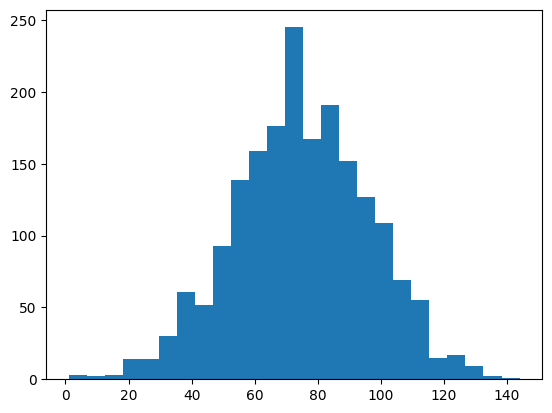

In [5]:
plt.hist(data_scores['Rowp'], bins=25)

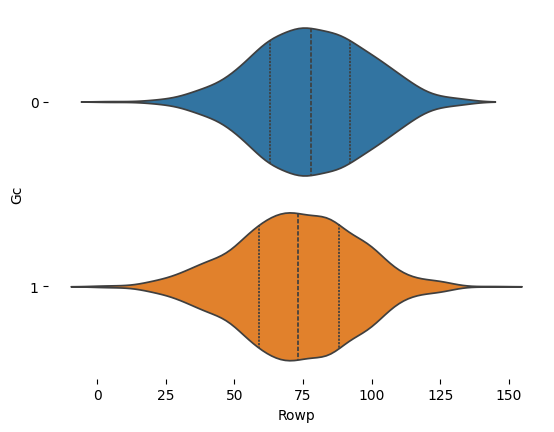

In [6]:
sns.violinplot(data_scores, x='Rowp', y='Gc', inner='quart',hue='Gc')
sns.despine(top=True, right=True, bottom=True, left=True)

So I spent way to much time trying to get that histogram because appparently there is a space at the front of my column names. I'm leaving it that way bc it tells the story of my model.

In [7]:
gc_encode = pd.Categorical(data_scores.Gc)
gc_encode

['0', '1', '1', '1', '0', ..., '1', '0', '0', '0', '0']
Length: 1905
Categories (2, object): ['0', '1']

In [8]:
gc_idx = gc_encode.codes
gc_idx

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

In [9]:
gc_coords = {"gc": gc_encode.categories}
gc_coords

{'gc': Index(['0', '1'], dtype='object')}

##Picking Distributions##

I need to choose distributions to use for my prior and likelihood. I know almost nothing about this data set, just that it looks a little normal. I think I will use something like the weibull distribution because I believe in students abilities to score well more often than they score poorly.

I want my likelihood to be something like this:

<Axes: >

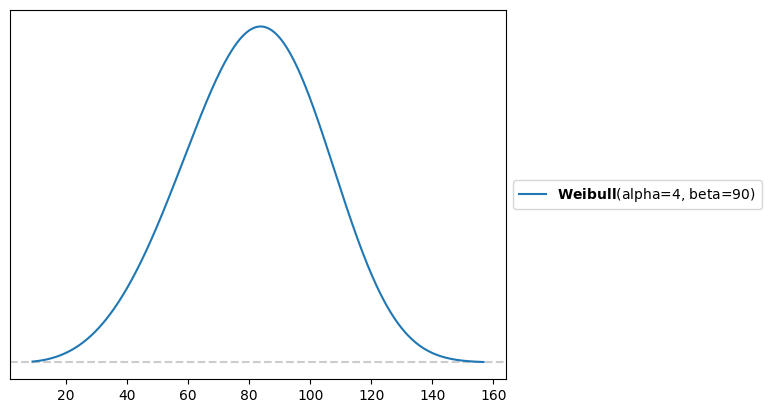

In [10]:
wb_l = pz.Weibull(alpha = 4, beta = 90)
wb_l.plot_pdf()

I don't know exactly how stretched/squished the distribution should be or where it will be centered, so I think I will use a gamma distribution for my alpha prior because I think its positive and between 1 and 4. My beta prior will be a scaled beta distribution because I didn't know what to pick and I don't know exactly where the data is centered.

<Axes: >

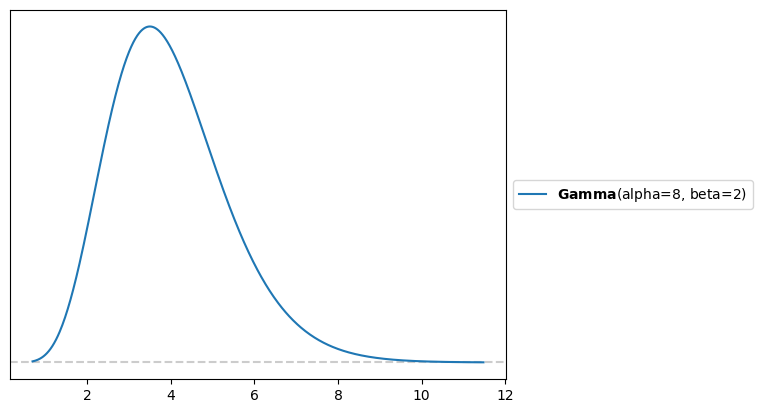

In [11]:
g_ap = pz.Gamma(alpha = 8, beta = 2)
g_ap.plot_pdf()

<Axes: >

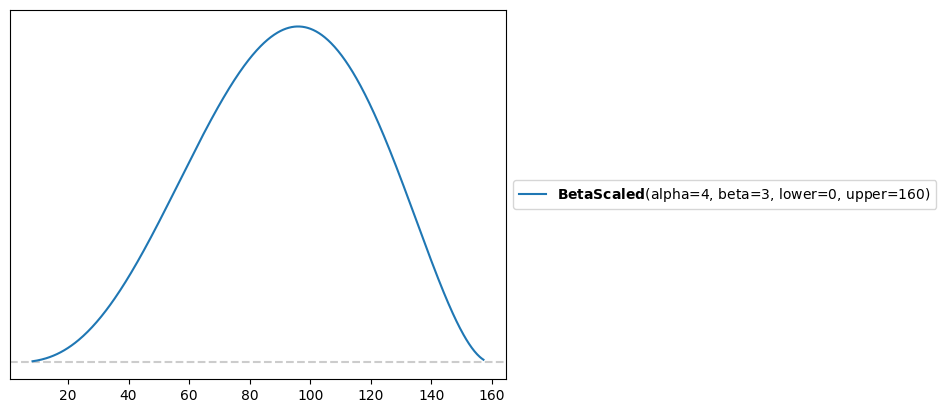

In [12]:
b_bp = pz.BetaScaled(alpha = 4, beta = 3, lower = 0, upper = 160)
b_bp.plot_pdf()

I am going to make hyper priors for the gamma distribution because I decided to do that one arbitrarily. I'm less confident in the shape of my data than where the middle is. For my alpha hyperprior I will use an exponential distribution because its weakly informative. For my beta hyperprior I will use a half normal distribution.

<Axes: >

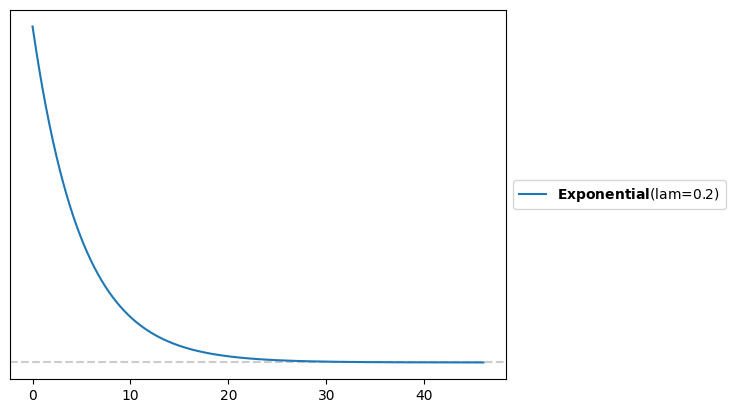

In [13]:
e_ahp = pz.Exponential(lam = .2)
e_ahp.plot_pdf()

<Axes: >

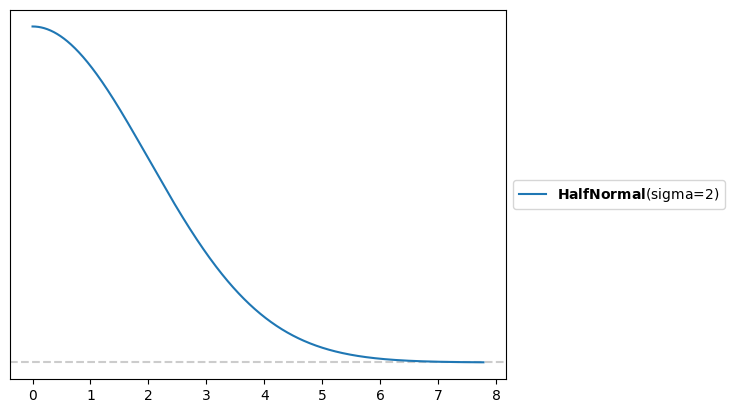

In [14]:
hn_bhp = pz.HalfNormal(sigma = 2)
hn_bhp.plot_pdf()

##Model 1 weibull likelihood, ##

In [15]:
with pm.Model(coords=gc_coords) as test_scores_h_model:
    # hyperpriors
    E_ahp = pm.Exponential('alpha_gamma', lam = 0.2)
    Hn_bhp = pm.HalfNormal('beta_gamma', sigma = 2)

    # priors.
    G_ap = pm.Gamma('alpha_weibull', alpha = E_ahp, beta = Hn_bhp, dims = 'gc')

    B_bp = pm.Beta('beta_unscaled', alpha = 4, beta = 3, dims = 'gc')
    Bs_bp = pm.Deterministic('betaS_weibull', 160*B_bp, dims = 'gc')

    #likelihood
    Weibull_likelihood = pm.Weibull('Wl', alpha = G_ap[gc_idx], beta = Bs_bp[gc_idx], observed = data_scores.Rowp)

    idata_scores_ht = pm.sample()

Output()

Output()

In [16]:
#non heirarchical model to see the difference
with pm.Model(coords=gc_coords) as test_scores_nh_model:

    # priors.
    G_ap = pm.Gamma('alpha_weibull', alpha = 8, beta = 2, dims = 'gc')

    B_bp = pm.Beta('beta_unscaled', alpha = 4, beta = 3, dims = 'gc')
    Bs_bp = pm.Deterministic('betaS_weibull', 160*B_bp, dims = 'gc')

    #likelihood
    Weibull_likelihood = pm.Weibull('Wl', alpha = G_ap[gc_idx], beta = Bs_bp[gc_idx], observed = data_scores.Rowp)

    idata_scores_nh = pm.sample()

Output()

Output()

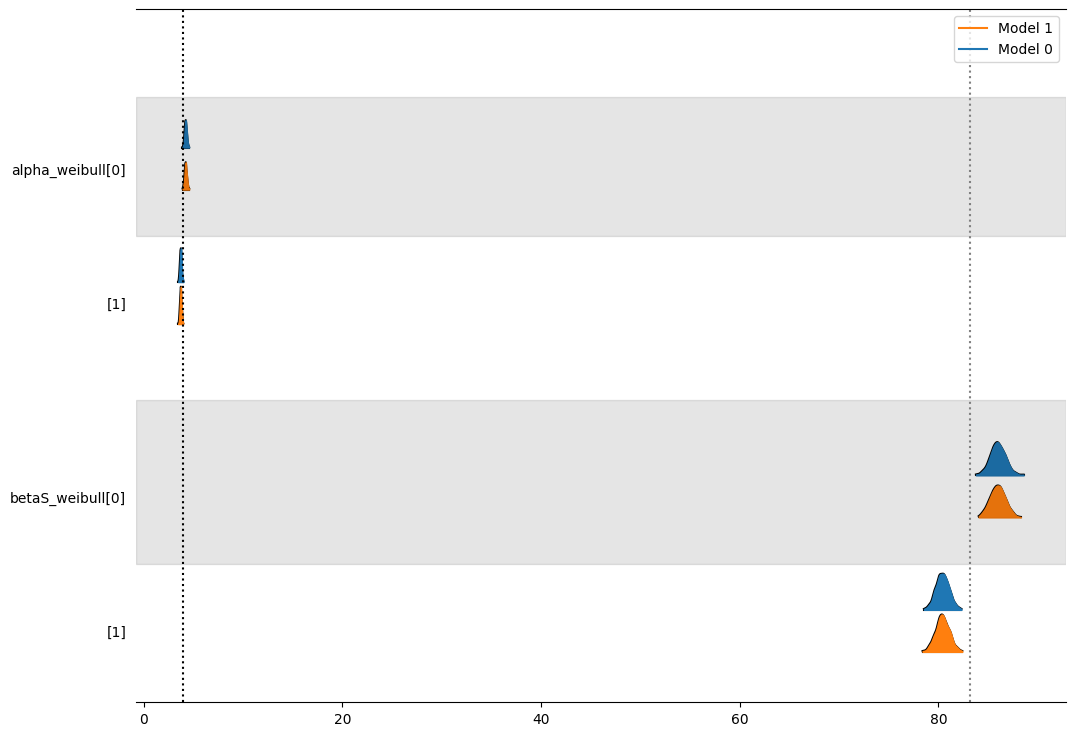

In [17]:
axes = az.plot_forest([idata_scores_ht, idata_scores_nh], kind="ridgeplot",
                      var_names=['alpha_weibull', 'betaS_weibull'],
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

# Using separate lines to calculate and plot the mean for each variable
y_lims = axes[0].get_ylim()
alpha_mean = idata_scores_ht.posterior['alpha_weibull'].mean()
betaS_mean = idata_scores_ht.posterior['betaS_weibull'].mean()

# Plot vertical lines for the means of each variable
axes[0].vlines(alpha_mean, *y_lims, color="k", ls=":")
axes[0].vlines(betaS_mean, *y_lims, color="gray", ls=":")

array([[<Axes: title={'center': 'alpha_gamma'}>,
        <Axes: title={'center': 'alpha_gamma'}>],
       [<Axes: title={'center': 'alpha_weibull'}>,
        <Axes: title={'center': 'alpha_weibull'}>],
       [<Axes: title={'center': 'betaS_weibull'}>,
        <Axes: title={'center': 'betaS_weibull'}>],
       [<Axes: title={'center': 'beta_gamma'}>,
        <Axes: title={'center': 'beta_gamma'}>],
       [<Axes: title={'center': 'beta_unscaled'}>,
        <Axes: title={'center': 'beta_unscaled'}>]], dtype=object)

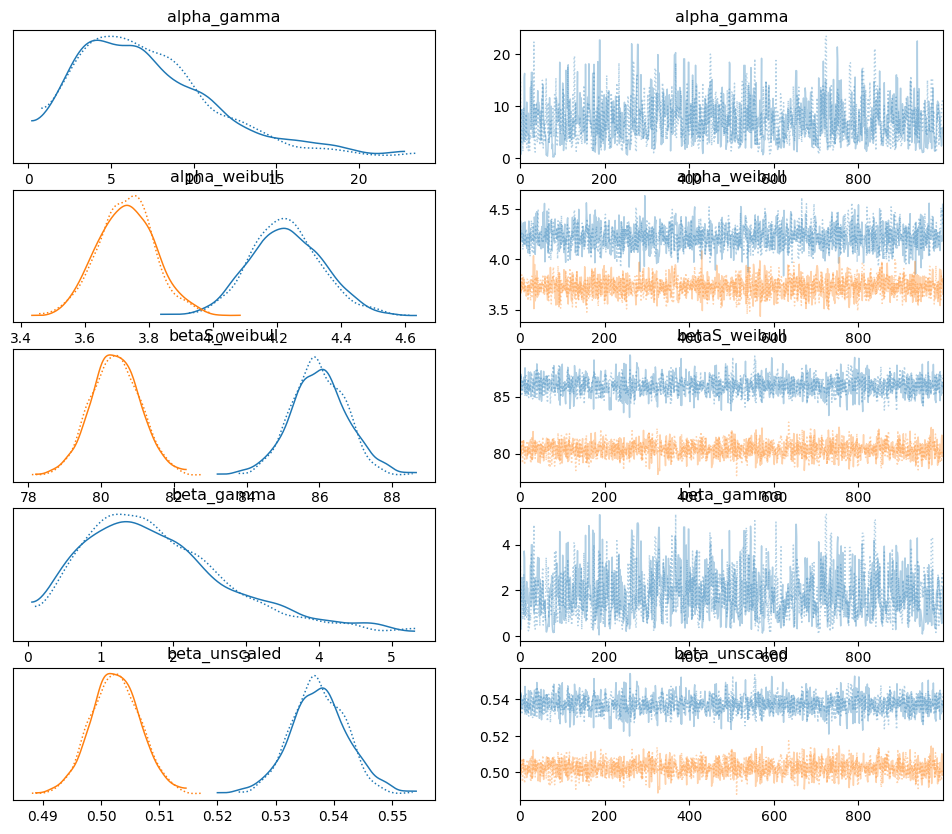

In [18]:
az.plot_trace(idata_scores_ht)

In [19]:
az.rhat(idata_scores_ht)

<xarray.Dataset> Size: 72B
Dimensions:        (gc: 2)
Coordinates:
  * gc             (gc) <U1 8B '0' '1'
Data variables:
    alpha_gamma    float64 8B 1.001
    alpha_weibull  (gc) float64 16B 1.005 1.007
    betaS_weibull  (gc) float64 16B 1.003 1.001
    beta_gamma     float64 8B 1.001
    beta_unscaled  (gc) float64 16B 1.003 1.001

In [20]:
pm.sample_posterior_predictive(
    idata_scores_ht, model = test_scores_h_model, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Wl'>

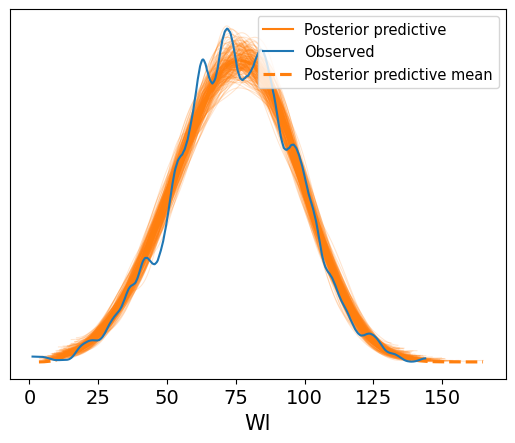

In [21]:
az.plot_ppc(idata_scores_ht, num_pp_samples=200, colors=["C1", "C0", "C1"])

I'm a little confused because my MCMCs don't look very healthy (they are a lot wider than the ones in the exercises), but my rhat values are close together. I think this could be an issue with the distributions and numbers I chose.